# Simple Momentum Strategy

This notebook explores a basic momentum strategy setup on a given stock. The flow is as follow:

1. Retrieve daily price for a group of stocks (QQQ, TLT, GLD, RWO) from YFinance and compute the basic statistics for further analysis.
2. Establish the rule for our signal and implement it into our dataset
3. Compute the performance metric of this signal strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

**Step 1**: Download daily price data for QQQ, TLT, GLD, RWO from yahoo finance since 2016-01-01. Adjusted closing price has been removed from the dataset, so we will use 'close' instead to compute daily returns. 

This should be a DataFrame with index=date, columns=ticker and values=daily returns.

In [2]:
tickers = ['QQQ', 'TLT', 'GLD', 'RWO']
data = yf.download(tickers, start='2016-01-01')['Close'] # Only retrieve the close
data.head()

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_10446/852074794.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2016-01-01')['Close'] # Only retrieve the close
[*********************100%***********************]  4 of 4 completed


Ticker,GLD,QQQ,RWO,TLT
Date,,,,
2016-01-04,102.889999,101.845543,32.284359,92.705406
2016-01-05,103.180000,101.668816,32.675518,92.331352
2016-01-06,104.669998,100.692215,32.424053,93.575546
2016-01-07,106.150002,97.539200,31.844305,93.743530
2016-01-08,105.680000,96.739326,31.362343,94.163368


In [3]:
# Compute the daily returns of each ticker
# Method 1
returns = data.pct_change().dropna() # using pandass pct_change() method

# Method 2
returns = data / data.shift(1) - 1 # Use the shift method to align prices
returns = returns.dropna()

returns.head()

Ticker,GLD,QQQ,RWO,TLT
Date,,,,
2016-01-05,0.002819,-0.001735,0.012116,-0.004035
2016-01-06,0.014441,-0.009606,-0.007696,0.013475
2016-01-07,0.014140,-0.031313,-0.017880,0.001795
2016-01-08,-0.004428,-0.008201,-0.015135,0.004479
2016-01-11,-0.008895,0.003077,0.003118,-0.010944


**Step 2**: Compute our signal for the momentum strategy. The function *compute_momentum* computes a simple momentum signal.

To elaborate, the compute_momentum() function:
- Takes in a DataFrame with index = date, columns=ticker and values containing daily returns. 
- Returns a new DataFrame with index = date, columns=ticker and values containing the momentum signal for the ticker on that day. 
  - The momentum signal for each ticker is defined as the annualized sharpe ratio of the past 252 days.

In [5]:
# Define the compute_momentum function
def compute_momentum(returns):
  window = 252  # Lookback period of 252 trading days (1 year)
  ''' Computational logic for momentum signal
    1. We specify the rolling window to be 252 days
    2. Using the rolling_window method in pandas, we compute the rolling mean and rolling standard deviation of the returns over the specified window
    3. The momentum signal is then calculated as the annualized Sharpe ratio: (rolling mean / rolling std) * sqrt(252)
  '''
  momentum = returns.rolling(window=window).mean() / returns.rolling(window=window).std() * np.sqrt(252)
  return momentum

In [6]:
momentum = compute_momentum(returns)
momentum

Ticker,GLD,QQQ,RWO,TLT
Date,,,,
2016-01-05,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN
2016-01-11,NaN,NaN,NaN,NaN
...,...,...,...,...
2026-01-13,2.754553,1.040130,1.008139,0.656312
2026-01-14,2.858553,1.007043,0.988236,0.707509
2026-01-15,2.799399,1.026474,0.964347,0.719503


**Step 3**: Create a portfolio out of the given stocks. The function *compute_portfolio* 

To elaborate, the compute_portfolio function:
- Takes as input the DataFrame "momentum" that we have computed in the previous section. 
- Returns a new DataFrame "portfolio" which has the same index/columns and has as values portfolio weights. 
  - The weights are computed as follows: On each date, equal-weight long the tickers with a momentum signal above 1.

In [7]:
def compute_portfolio(momentum):
  ''' Computational logic for portfolio weights
    1. Create a boolean DataFrame where True indicates momentum signal > 1
    2. Calculate the number of assets with momentum signal > 1 for each date
    3. Assign equal weights to those assets and 0 weight to others
  '''
  long_signals = momentum > 1 # Create a boolean DataFrame where True indicates momentum signal > 1
  num_long = long_signals.sum(axis=1) # Count number of assets with momentum signal > 1 for each date
  portfolio = long_signals.div(num_long, axis=0).fillna(0) # Assign equal weights to those assets and 0 weight to others
  return portfolio

In [8]:
# Output the portfolio weights
portfolio = compute_portfolio(momentum)
portfolio

Ticker,GLD,QQQ,RWO,TLT
Date,,,,
2016-01-05,0.000000,0.000000,0.000000,0.0
2016-01-06,0.000000,0.000000,0.000000,0.0
2016-01-07,0.000000,0.000000,0.000000,0.0
2016-01-08,0.000000,0.000000,0.000000,0.0
2016-01-11,0.000000,0.000000,0.000000,0.0
...,...,...,...,...
2026-01-13,0.333333,0.333333,0.333333,0.0
2026-01-14,0.500000,0.500000,0.000000,0.0
2026-01-15,0.500000,0.500000,0.000000,0.0


**Step 4**: Computing the portfolio returns. We will use the "portfolio" returned in Step(3) and the returns generated in Step(1), compute the returns to the simple momentum strategy. From there, we will analyse:
- The annualized sharpe ratio of the strategy
- The annualized sharpe ratio within each year

Byeond that, we will also try to understand how correlated our strategy is with the underlying tickers and end off with a plot of the cumulative sum of the returns through time.

In [9]:
rets = data.pct_change()
strategy_rets = (portfolio.shift(1) * rets).sum(axis=1)
strategy_rets = strategy_rets.dropna()
print("Strategy Returns:")
strategy_rets

Strategy Returns:


Date
2016-01-04    0.000000
2016-01-05    0.000000
2016-01-06    0.000000
2016-01-07    0.000000
2016-01-08    0.000000
                ...   
2026-01-13   -0.001421
2026-01-14    0.001437
2026-01-15   -0.001264
2026-01-16   -0.002828
2026-01-20    0.011795
Length: 2526, dtype: float64

In [13]:
# Annualized Sharpe Ratio
annualized_sharpe = np.sqrt(252) * (strategy_rets.mean() / strategy_rets.std())
print("Annualized Sharpe Ratio:", annualized_sharpe)

# Annualized Sharpe Ratio within each year
sharpe = lambda x: np.sqrt(252) * (x.mean() / x.std()) # Define the lanbda function for sharpe calculation
annualized_sharpe_by_year = strategy_rets.resample('Y').apply(sharpe) # Resample by year and apply the sharpe function
print("Annualized Sharpe Ratio by Year:")
annualized_sharpe_by_year

Annualized Sharpe Ratio: 1.258943819306506
Annualized Sharpe Ratio by Year:


/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_10446/3278728174.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annualized_sharpe_by_year = strategy_rets.resample('Y').apply(sharpe) # Resample by year and apply the sharpe function
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_10446/3278728174.py:6: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = lambda x: np.sqrt(252) * (x.mean() / x.std()) # Define the lanbda function for sharpe calculation


Date
2016-12-31         NaN
2017-12-31    2.670447
2018-12-31   -0.024993
2019-12-31    1.015503
2020-12-31    1.528311
2021-12-31    1.411044
2022-12-31   -0.737295
2023-12-31    1.171866
2024-12-31    1.802069
2025-12-31    2.553750
2026-12-31    9.566020
Freq: YE-DEC, dtype: float64

In [14]:
# Compute the correlaton between strategy returns and individual asset returns
correlations = returns.corrwith(strategy_rets)
print("Correlations with Strategy Returns:")
correlations

Correlations with Strategy Returns:


Ticker
GLD    0.436570
QQQ    0.398655
RWO    0.227909
TLT    0.173146
dtype: float64

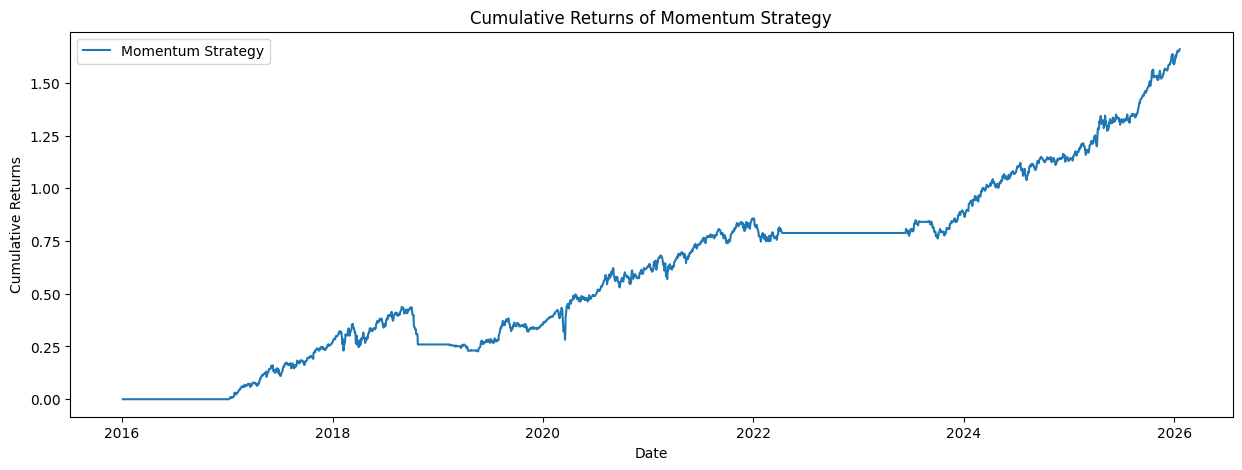

In [15]:
# Cumulative returns plot of the strategy
cumulative_returns = strategy_rets.cumsum()
plt.figure(figsize=(15, 5))
plt.plot(cumulative_returns, label='Momentum Strategy')
plt.title('Cumulative Returns of Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()